# AIPI 590 - XAI | Assignment #2
### Interpretable ML
### Shaunak Badani


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shaunak-badani/XAI/blob/main/Assignment02/InterpretableML.ipynb)

In [27]:
!pip install pygam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 18.4 MB/s eta 0:00:00


In [60]:
import os
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from scipy import stats
from pygam import LogisticGAM, s

In [2]:
!rm -r ./sample_data

repo_name = "XAI" # Change to your repo name
git_path = f"https://github.com/shaunak-badani/{repo_name}.git" #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Assignment02'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'XAI' already exists and is not an empty directory.
/content/XAI/Assignment02
InterpretableML.ipynb


In [3]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

In [4]:
filename = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
churn_data = pd.read_csv(os.path.join(path, filename))

# Exploratory Data Analysis

In [5]:
churn_data.shape

(7043, 21)

In [6]:
churn_data = churn_data.replace({'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0, ' ': 0}).infer_objects(copy=False)

<ipython-input-6-7b648db03076>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  churn_data = churn_data.replace({'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0, ' ': 0}).infer_objects(copy=False)


In [7]:
numeric_columns_interpreted_as_object = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "TotalCharges"]
churn_data[numeric_columns_interpreted_as_object] = churn_data[numeric_columns_interpreted_as_object].apply(pd.to_numeric)

In [8]:
numeric_columns = churn_data.select_dtypes(include = 'number').columns.to_list()
print(len(numeric_columns))
churn_data[numeric_columns].describe()

16


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,0.483033,0.299588,32.371149,0.903166,0.421837,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.592219,64.761692,2279.734304,0.265370
std,0.368612,0.499748,0.458110,24.559481,0.295752,0.493888,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.491457,30.090047,2266.794470,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.500000,398.550000,0.000000
50%,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,70.350000,1394.550000,0.000000
75%,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.850000,3786.600000,1.000000
max,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,118.750000,8684.800000,1.000000


In [9]:
columns_to_one_hot = ["gender", "InternetService", "Contract", "PaymentMethod"]
churn_data = pd.get_dummies(churn_data, columns = columns_to_one_hot, dtype = 'int64')

In [10]:
columns = set(churn_data.select_dtypes(include = 'number').columns.to_list()).difference({'Churn'})

## Checking assumptions of linear regression

#### Plotting each predictor vs target (churn)

In [11]:
len(columns)

27

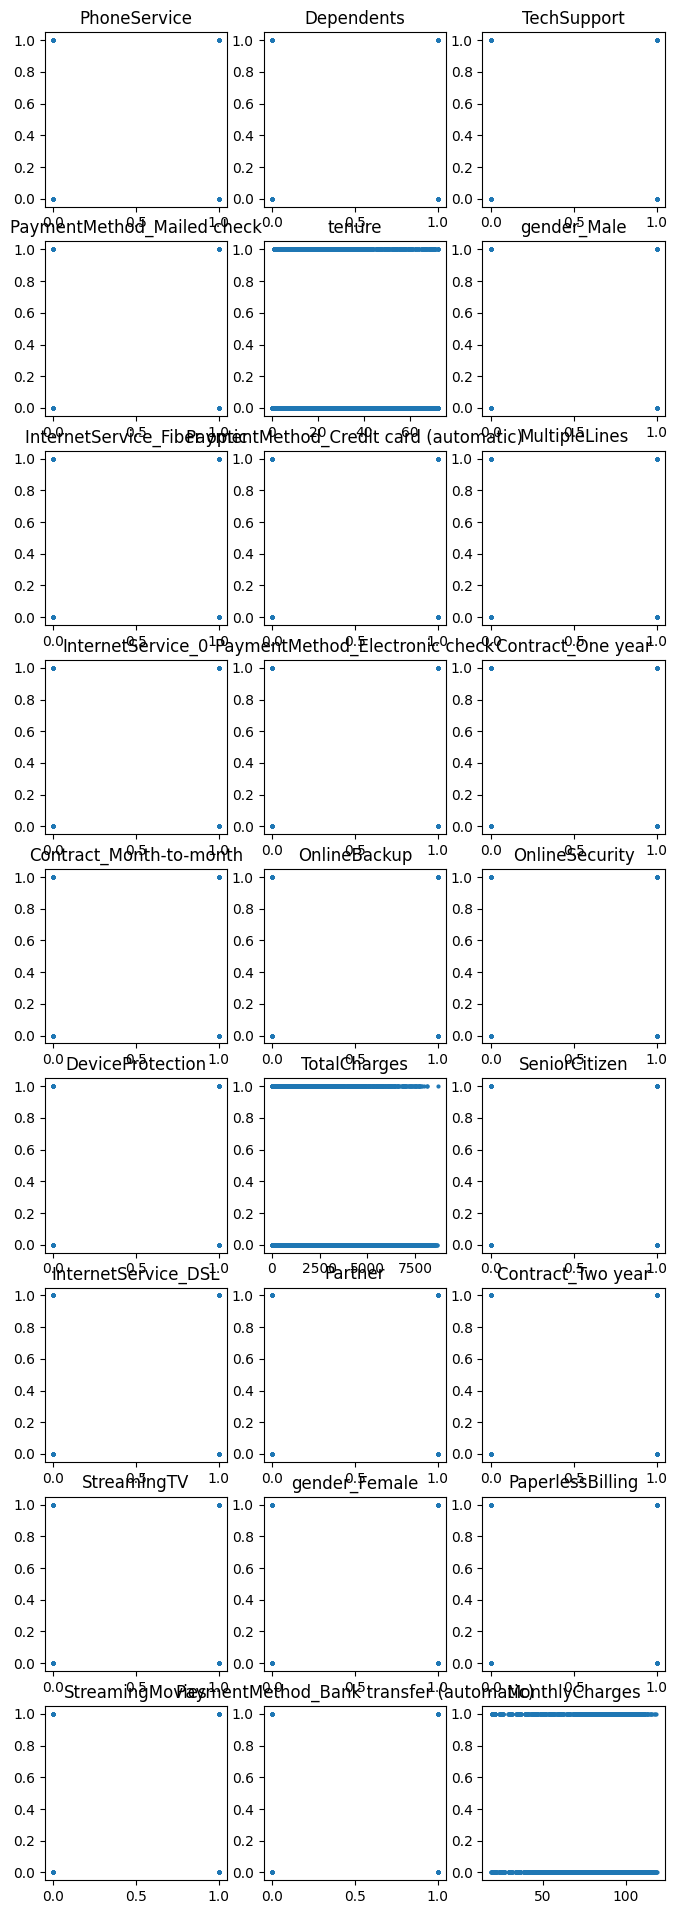

In [12]:
fig, axes = plt.subplots(9, 3, figsize = (8, 24))

for i, column in enumerate(columns):
  a, b = int(i / 3), int(i % 3)
  axes[a, b].set_title(f"{column}")
  axes[a, b].scatter(churn_data[column], churn_data["Churn"], s = 4)

#### Residuals vs predicted values

In [52]:
X = churn_data[list(columns)].to_numpy()
y = churn_data["Churn"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [53]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_preds_test = model.predict(X_test_scaled)
residuals = y_test - y_preds_test

Text(0, 0.5, 'Residuals')

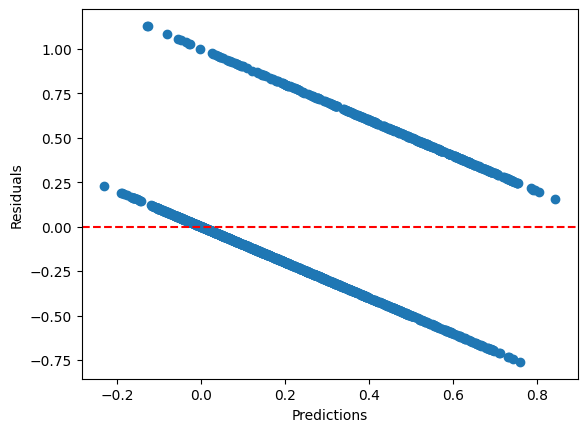

In [16]:
plt.scatter(y_preds_test, residuals)
plt.xlabel("Predictions")
plt.axhline(y=0, color='r', linestyle='--')
plt.ylabel("Residuals")

It's difficult to interpret linearity from the above plot since the y value is either $ 1 - x $ or $ -x $ leading to two straight lines forming in the above plot.

No funnels in the residual plots, so we can say that Homoscedasticity is observed.

## Independence of Observations

#### Durbin-Watson Test

In [17]:
diff = np.diff(residuals)
dw = np.sum(diff**2) / np.sum(residuals**2)
print(dw)

2.0649358291424527


- The Durbin-Watson value is close to 2, so there is no first order auto-correlation.

## Normality of Residuals

#### Q-Q plots of residuals



((array([-3.29516378, -3.03723403, -2.89375266, ...,  2.89375266,
          3.03723403,  3.29516378]),
  array([-0.76053836, -0.74404933, -0.73521432, ...,  1.08099995,
          1.12543441,  1.12847713])),
 (0.3760778611620356, -0.0014627727279899522, 0.9801582146637091))

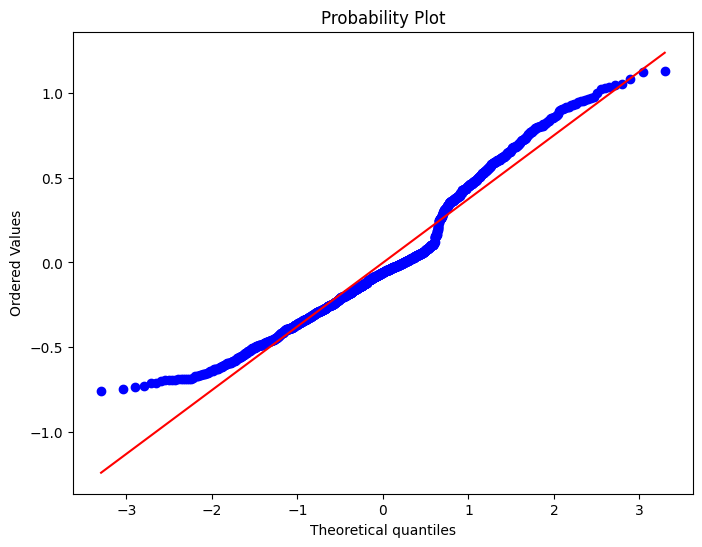

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot = ax)

Since the points are following a roughly 45 degree line, the residuals can be said to be normally distributed.

# Linear Regression with Interpretability

In [19]:
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_preds_test = linear_model.predict(X_test_scaled)
y_preds_classes = np.round(y_preds_test)
acc = (y_preds_classes == y_test).sum() / y_test.size
print(f"Accuracy of linear regression model: {acc}")

Accuracy of linear regression model: 0.7991483321504613


In [20]:
print(linear_model.coef_)

[-0.02078007 -0.01283487 -0.02532247 -0.00904722 -0.05014845 -0.0022713
  0.04552886 -0.01227386  0.02413048 -0.04432914  0.02540188 -0.02483949
  0.02671359 -0.02227532 -0.02557625 -0.00518306 -0.10123691  0.01744445
 -0.00914399  0.00236433 -0.00742891  0.01752048  0.0022713   0.02268556
  0.00786506 -0.00765414  0.07163206]


In [21]:
len(list(columns))

27

In [22]:
sorted_indices = np.argsort(linear_model.coef_)
coefficients = linear_model.coef_[sorted_indices]
sorted_columns = np.array(list(columns))[sorted_indices]
colors = ['blue' if coef > 0 else 'orange' for coef in coefficients]

Text(0.5, 1.0, 'Linear Model coefficients - Churn Dataset')

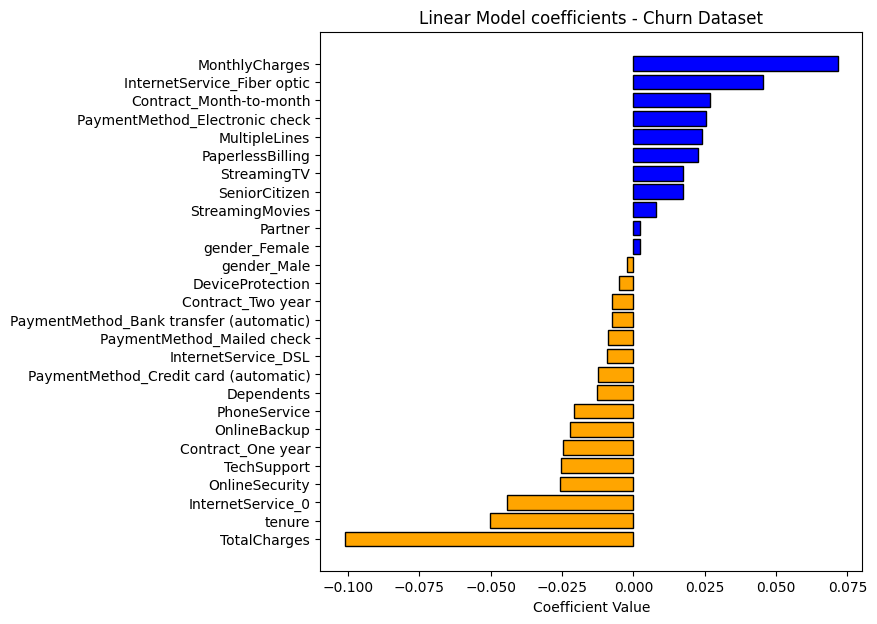

In [23]:
fig = plt.figure(figsize = (7, 7))

plt.barh(sorted_columns, coefficients, color = colors, edgecolor = 'black')
plt.xlabel('Coefficient Value')
plt.title('Linear Model coefficients - Churn Dataset')

The Linear Regression model has an accuracy of 79.9%.

Coefficient inference:
- Gender has little effect on the churn rate, with females tending to leave more than males.
- The MonthlyCharges is the factor most responsible for customers tending to leave.
- The TotalCharges is the factor that retains most of the customers.
- Not offering internet service (InternetService_0) surprisingly makes people stay. It is possible that the customers don't want Internet service, thereby reducing the cost of the plan.


# Logistic Regression with Interpretability

In [24]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train)
y_preds_test = logistic_model.predict(X_test_scaled)
acc = (y_preds_test == y_test).sum() / y_test.size
print(f"Accuracy of logistic regression model: {acc}")

Accuracy of logistic regression model: 0.7977288857345636


In [25]:
sorted_indices = np.argsort(logistic_model.coef_.squeeze())
coefficients = logistic_model.coef_.squeeze()[sorted_indices]
sorted_columns = np.array(list(columns))[sorted_indices]
colors = ['blue' if coef > 0 else 'orange' for coef in coefficients]

Text(0.5, 1.0, 'Logistic Regression Model coefficients - Churn Dataset')

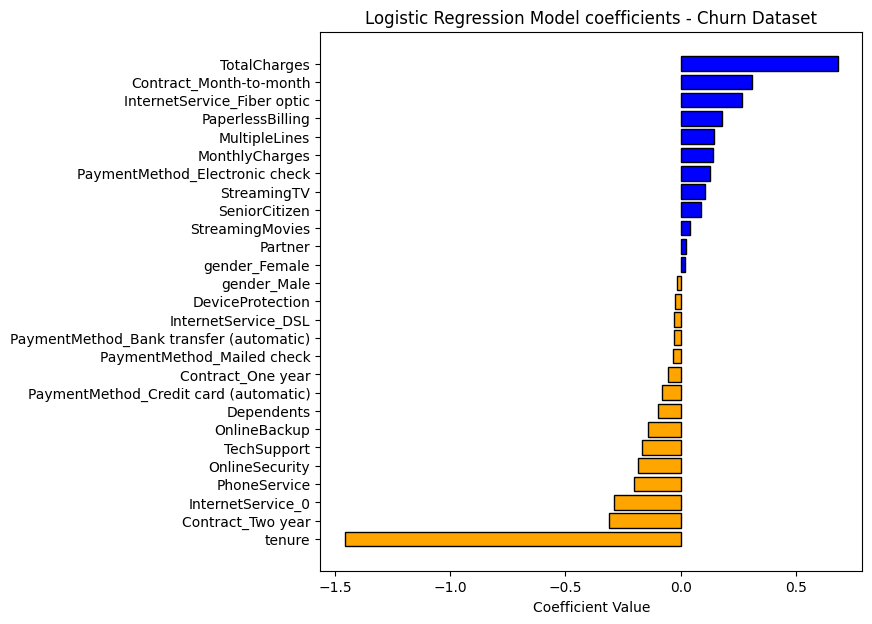

In [26]:
fig = plt.figure(figsize = (7, 7))

plt.barh(sorted_columns, coefficients, color = colors, edgecolor = 'black')
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Model coefficients - Churn Dataset')

The logistic model has an accuracy of 79.7%

Coefficients:
- The longer the tenure, the lesser the tendency of the customer to leave.
- TotalCharges was the most important factor which caused customers to leave, among all other factors.
- A month to month contract was also instrumental in making customers discontinue with the service.

# Generalized Additive Model with interpretability

In [32]:
from sklearn.datasets import load_diabetes

In [33]:
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

In [38]:
# The target variable needs to be positive for Gamma GLM
y = y - y.min() + 1  # Shift and scale to ensure all values are positive

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
from pygam import LinearGAM
from sklearn.metrics import mean_squared_error, r2_score
# Initilize GAM
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9))

# Find best smoothing parameters for each spline term
gam.gridsearch(X_train_scaled, y_train)

# Fit the model
gam.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gam = gam.predict(X_test_scaled)

# Calculate MSE and R^2
mse_gam = mean_squared_error(y_test, y_pred_gam)
r2_gam = r2_score(y_test, y_pred_gam)

print(f"GAM MSE: {mse_gam:.4f}, R^2: {r2_gam:.4f}")

gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


GAM MSE: 2750.6111, R^2: 0.4808
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     17.7204
Link Function:                     IdentityLink Log Likelihood:                                 -3136.0639
Number of Samples:                          353 AIC:                                             6309.5686
                                                AICc:                                             6311.784
                                                GCV:                                             3162.6608
                                                Scale:                                           2878.2281
                                                Pseudo R-Squared:                                   0.5501
Featu

<ipython-input-43-77b9b3dacd9c>:21: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


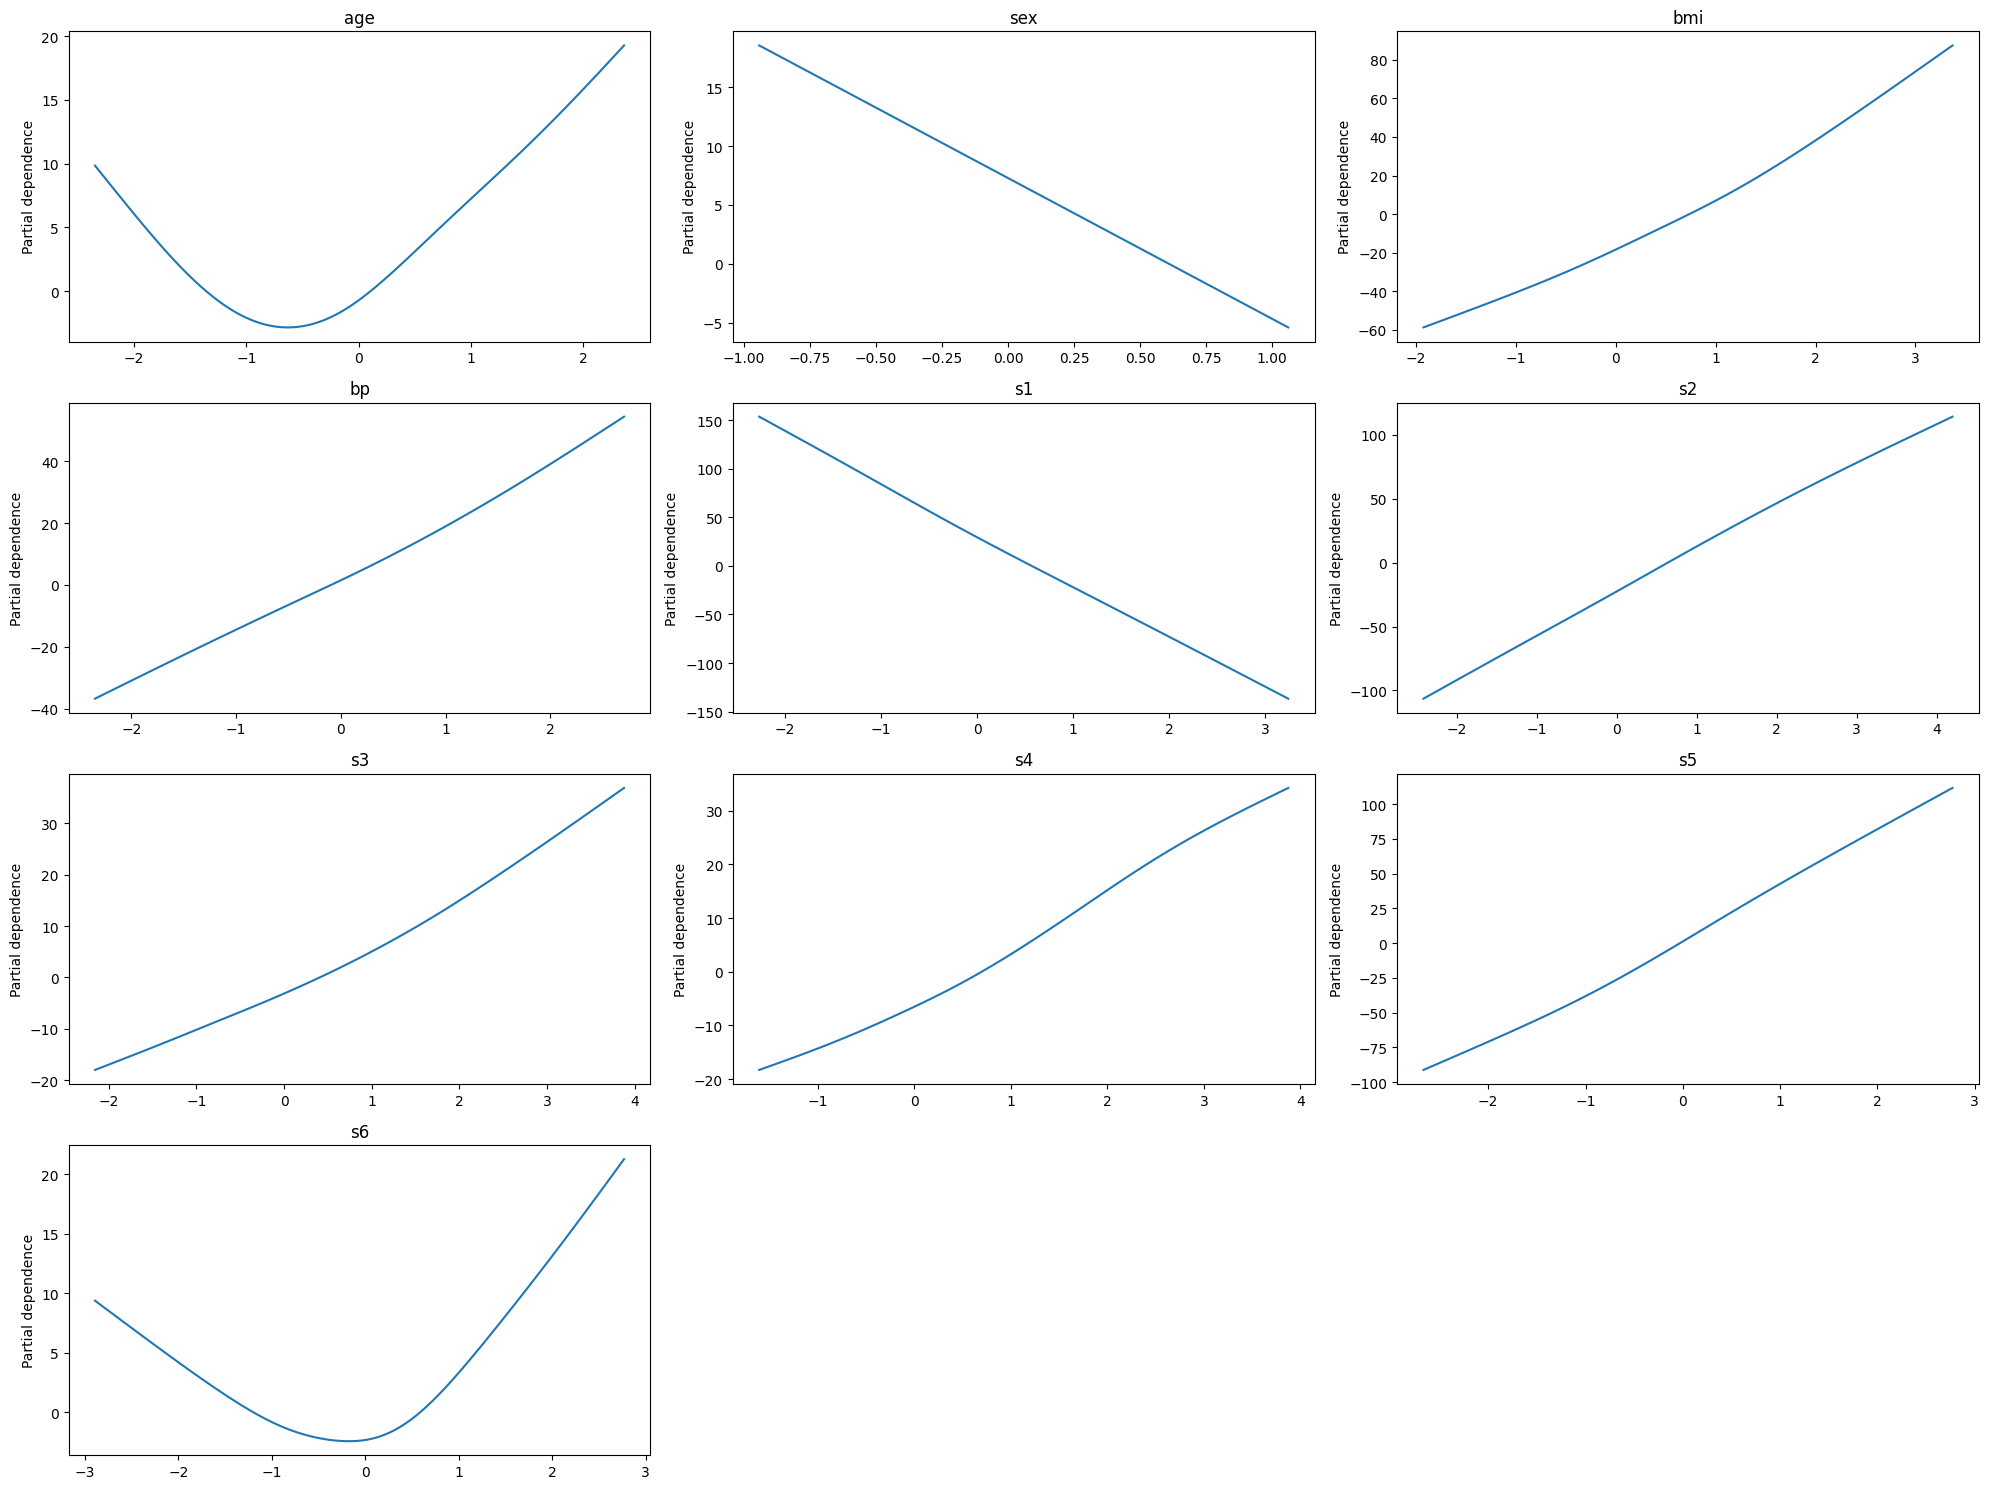

In [49]:
plt.figure(figsize=(20, 15))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(4, 3, i+1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))
    plt.title(diabetes.feature_names[i])
    plt.ylabel('Partial dependence')
plt.tight_layout()
plt.show()

In [61]:
l = s(0)
for i in range(1, X_train_scaled.shape[1]):
    l += s(i)

gam = LogisticGAM(l)
gam.gridsearch(X_train_scaled, y_train)

gam.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gam = gam.predict(X_test_scaled)
acc = accuracy_score(y_pred_gam, y_test)

100% (11 of 11) |########################| Elapsed Time: 0:00:53 Time:  0:00:53


In [62]:
print(f"Accuracy score for a Logistic GAM: {acc}")

Accuracy score for a Logistic GAM: 0.7963094393186657


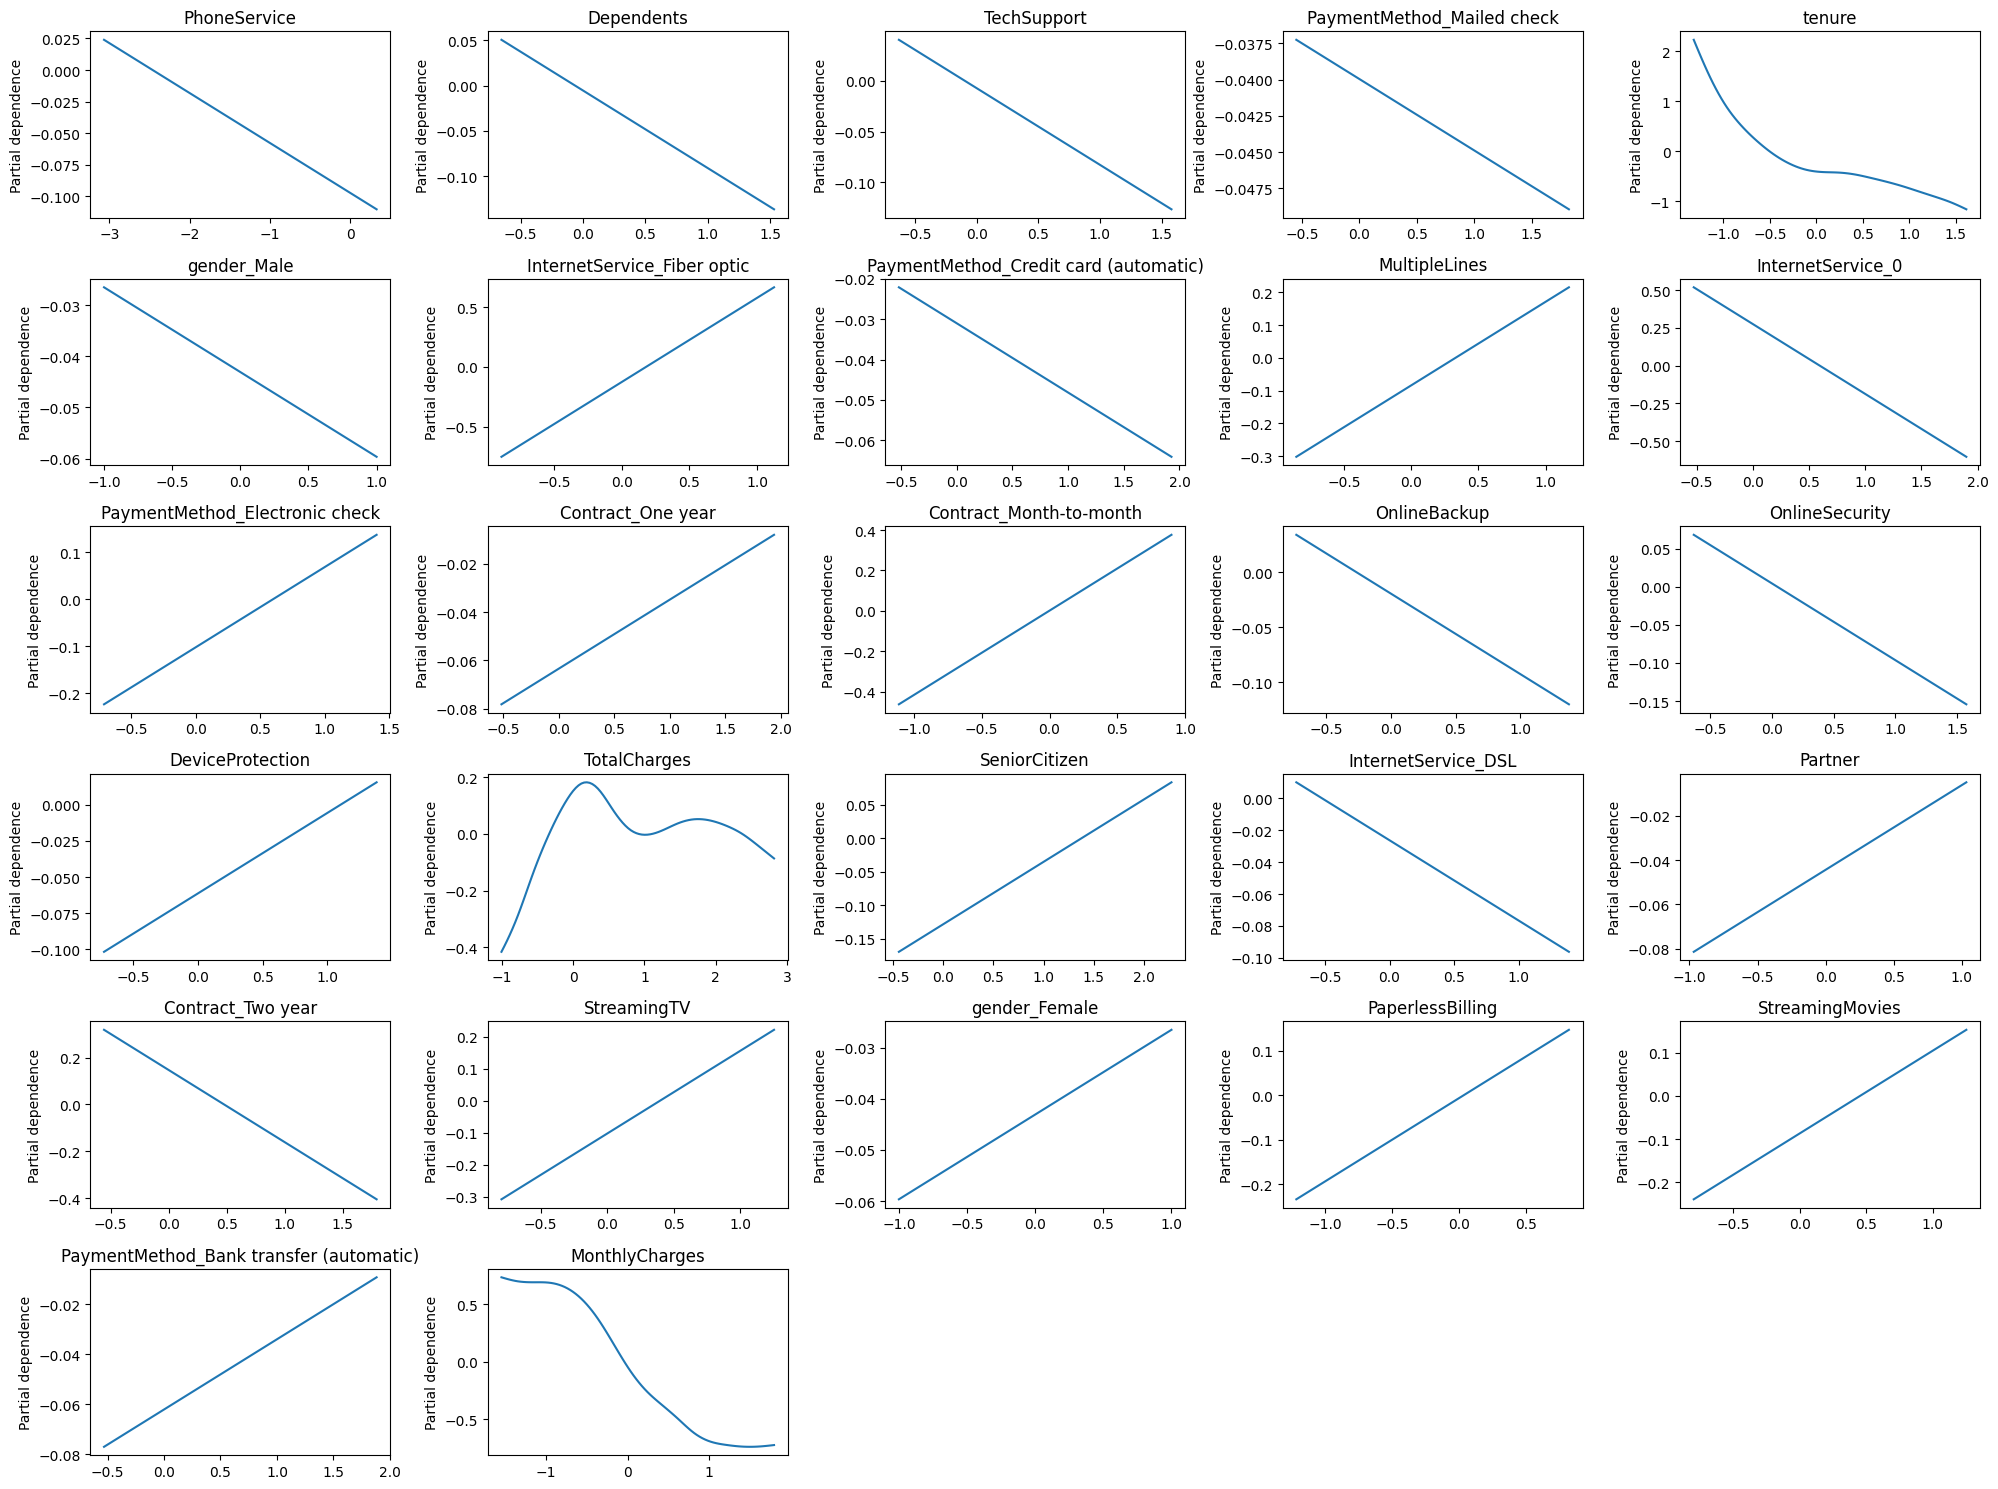

In [64]:
# Visualize GAM
plt.figure(figsize=(20, 15))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(6, 5, i+1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))
    plt.title(list(columns)[i])
    plt.ylabel('Partial dependence')
plt.tight_layout()
plt.show()

The Logistic GAM provided a model accuracy of 79.63%

Coefficient inference:
- Customers with a higher tenure tended to stay.
- A two year contract caused customers to stay.
- The monthly charges caused customers to leave.
- DSL internet service caused customers to stay.